# TP Integrador Aprendizaje Automático I

### Librerías

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import nbimporter
from funciones import *
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

### Carga de datos y exploración

In [44]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]


In [45]:
### Vista de datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [46]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [47]:
# Se analizan los tipos de datos que conforman el dataset
print(df.dtypes)

Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object


In [48]:
# Se convierte la columna 'Date' de string (object) a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Se toma como fecha base la mínima fecha del df
fecha_base = df['Date'].min()

# Se calcula el número de días desde la fecha base
df['Date'] = (df['Date'] - fecha_base).dt.days


In [49]:
#Se reemplaza 'Yes' por 1 y 'No' por 0 en las columnas RainToday y RainTomorrow
# errors='coerce' permite conservar los nan aún cambiando el tipo de datos a booleano
df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')

C:\Users\julia\AppData\Local\Temp\ipykernel_1848\84528137.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
C:\Users\julia\AppData\Local\Temp\ipykernel_1848\84528137.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')


In [50]:
#Se mapean las direcciones dadas ('SSW', 'S', 'SE', etc.) a números del 0 al 15 según las agujas del reloj
directions_mapping = {
    'N': 0,
    'NNE': 1,
    'NE': 2,
    'ENE': 3,
    'E': 4,
    'ESE': 5,
    'SE': 6,
    'SSE': 7,
    'S': 8,
    'SSW': 9,
    'SW': 10,
    'WSW': 11,
    'W': 12,
    'WNW': 13,
    'NW': 14,
    'NNW': 15
}

In [51]:
# Se reemplaza en df los nuevos valores
df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
df['WindDir3pm'] = df['WindDir3pm'].replace(directions_mapping)

C:\Users\julia\AppData\Local\Temp\ipykernel_1848\216544107.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_1848\216544107.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_1848\216544107.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

In [52]:
df.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,28233.000000,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26588.000000,26591.000000,26585.000000,27796.000000,...,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,1913.110367,11.263319,21.902078,2.050369,4.826499,6.891129,7.711110,41.835471,7.376378,8.048928,...,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,948.862211,5.709936,6.693168,6.384560,3.707995,3.867622,4.694183,14.186300,5.054644,4.503144,...,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,1082.000000,7.400000,16.600000,0.000000,2.200000,3.800000,4.000000,31.000000,2.000000,4.000000,...,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,1955.000000,10.900000,21.000000,0.000000,4.000000,7.400000,8.000000,39.000000,8.000000,8.000000,...,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,2739.000000,15.200000,26.200000,1.000000,6.600000,10.000000,12.000000,50.000000,12.000000,12.000000,...,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,3523.000000,33.900000,46.800000,119.400000,86.200000,14.300000,15.000000,122.000000,15.000000,15.000000,...,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


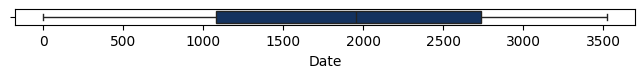

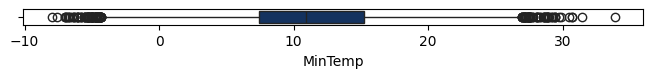

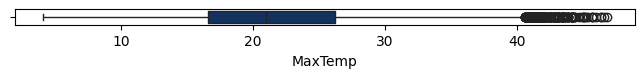

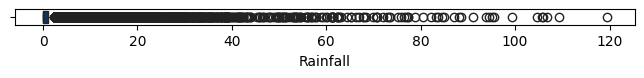

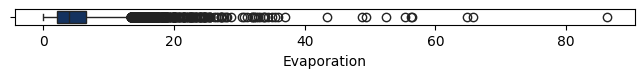

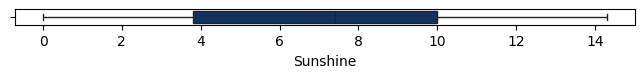

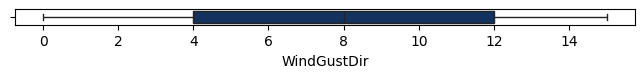

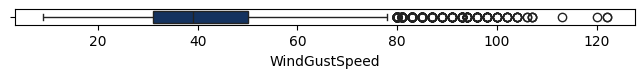

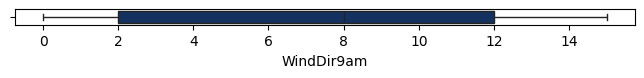

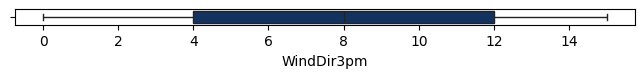

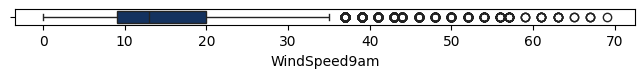

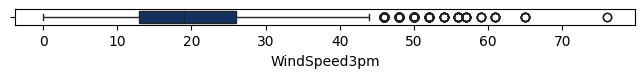

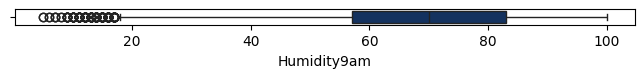

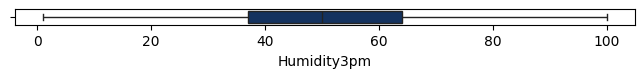

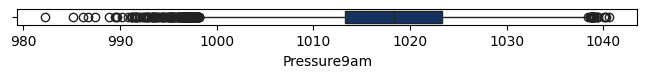

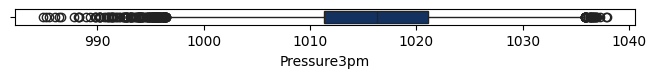

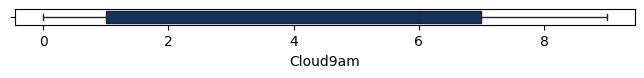

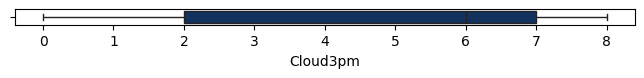

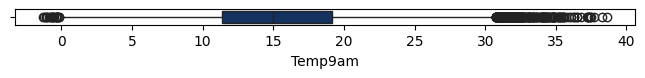

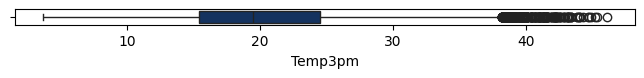

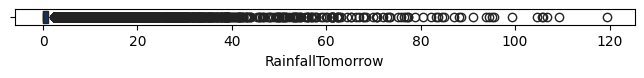

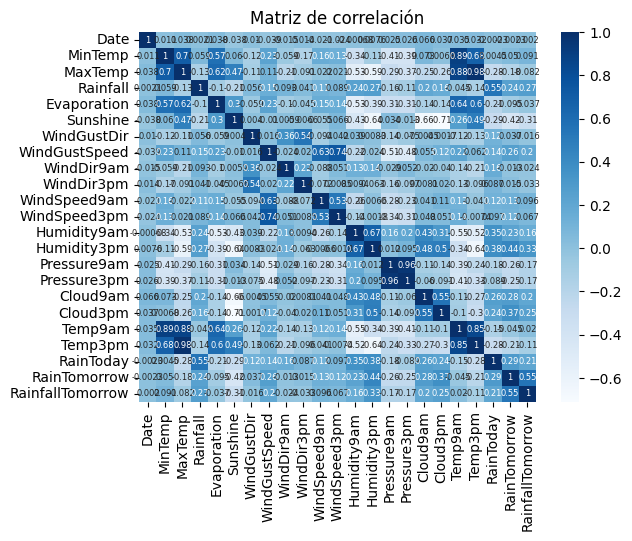

In [53]:
explorar(df)

### Partición del Dataframe

In [54]:
# Se chequea que todas las fechas tengan un valor
df['Date'].isna().sum()

0

Se particiona el df en df_train y df_test en una proporción aproximada de 80% 20%, correspondiendo los del df_train a los datos cronológicamente más antiguos.

In [55]:
# Ordenamiento por la columna 'Date'
df = df.sort_values('Date')

# Calcular el índice que corresponde al 80% del DataFrame
index_at_80_percent = int(len(df) * 0.8)

# Usar el índice para obtener la fecha en ese punto
date_at_80_percent = df.iloc[index_at_80_percent]['Date']

# Crear df_train y df_test basado en esta fecha
df_train = df[df['Date'] <= date_at_80_percent]
df_test = df[df['Date'] > date_at_80_percent]

# Mostrar el número de registros en cada conjunto
print(f"Entrenamiento: {len(df_train)} registros")
print(f"Prueba: {len(df_test)} registros")
print(f"Suma de registro Entrenamiento y Prueba: {len(df_test)+len(df_train)} registros")
print(f"Cantidad total de registros en df original: {df.shape[0]} registros")


Entrenamiento: 22590 registros
Prueba: 5643 registros
Suma de registro Entrenamiento y Prueba: 28233 registros
Cantidad total de registros en df original: 28233 registros


### Análisis de valores nulos

#### Primeros análisis

Se cuenta la cantidad de filas con al menos un valor nan. Dicho valor debe ser menor al 5% del total de registros. Se observa que el segundo valor supera al primero, por lo que deberá analizarse el tratamiento a dar a los valores nan para su reemplazo.

Observación: todo el análisis se hará sobre el df_train.

In [56]:
print(f'Número máximo de filas para eliminar: {int(0.05 * df_train.shape[0])}')

Número máximo de filas para eliminar: 1129


In [57]:
# Contar filas que contienen al menos un valor NaN
nan_rows_count = df_train.isna().any(axis=1).sum()

# Imprimir el resultado
print(f'Número de filas con al menos un valor NaN: {nan_rows_count}')


Número de filas con al menos un valor NaN: 11516


In [58]:
### Cantidad de valores faltantes.
df_train.isna().sum().sort_values(ascending=False)

Cloud3pm            7469
Cloud9am            7179
Sunshine            3962
Evaporation         2016
WindGustDir         1571
WindGustSpeed       1568
WindDir9am          1415
RainfallTomorrow     742
Rainfall             742
RainToday            742
RainTomorrow         742
Pressure9am          625
Pressure3pm          618
Humidity9am          605
Humidity3pm          561
WindDir3pm           414
Temp9am              372
Temp3pm              366
MinTemp              357
WindSpeed9am         350
MaxTemp              344
WindSpeed3pm         336
Location               0
Date                   0
dtype: int64

Se analiza a continuación cada variable, con su variable más correlacionada, y la cantidad de nulos de cada una:

In [59]:
df_con_nan=df_train
analisis_nan(df_con_nan)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Pressure3pm,0.072729,0
1,MinTemp,Temp9am,0.892961,357
2,MaxTemp,Temp3pm,0.982767,344
3,Rainfall,RainToday,0.550871,742
4,Evaporation,Temp9am,0.652501,2016
5,Sunshine,Cloud3pm,-0.708560,3962
6,WindGustDir,WindDir3pm,0.545980,1571
7,WindGustSpeed,WindSpeed3pm,0.742479,1568
8,WindDir9am,WindGustDir,0.368278,1415
9,WindDir3pm,WindGustDir,0.545980,414


In [60]:
# Se reemplazan los nan con la siguiente función, para las variables más correlacionadas
recrear_nan(df_train,'MinTemp','Temp9am')
analisis_nan(df_train)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Pressure3pm,0.072729,0
1,MinTemp,Temp9am,0.892996,347
2,MaxTemp,Temp3pm,0.982767,344
3,Rainfall,RainToday,0.550871,742
4,Evaporation,Temp9am,0.652501,2016
5,Sunshine,Cloud3pm,-0.708560,3962
6,WindGustDir,WindDir3pm,0.545980,1571
7,WindGustSpeed,WindSpeed3pm,0.742479,1568
8,WindDir9am,WindGustDir,0.368278,1415
9,WindDir3pm,WindGustDir,0.545980,414


Se observa que la mayoría de las variables no presenta una fuerte correlación con las demás, por lo que no resulta válido reconstruir los valores nulos mediante regresión lineal.
Es por eso que se hace a continuación un análisis más detallado para estas variables.

#### Matriz de distancias geodésicas

Se construye una matriz con las distancias entre ciudades, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas:

In [61]:
# Coordenadas de las ciudades
cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'Dartmoor': (-37.9225, 141.2760),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'MountGambier': (-37.8284, 140.7804),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753)
}

# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())

# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)

# Mostrar la matriz de distancias
print(dist_matrix)


                 Adelaide Canberra   Cobar Dartmoor Melbourne  \
Adelaide              0.0   960.32  773.97   409.76    654.36   
Canberra           960.32      0.0  519.56   761.08    467.02   
Cobar              773.97   519.56     0.0   825.72    705.11   
Dartmoor           409.76   761.08  825.72      0.0    324.63   
Melbourne          654.36   467.02  705.11   324.63       0.0   
MelbourneAirport   637.49   466.79  690.56   315.23     19.32   
MountGambier       376.54   798.82  840.92    44.84    368.24   
Sydney            1164.53   246.85   568.4   1002.5    713.86   
SydneyAirport     1160.17   239.41   569.1   995.89    706.42   

                 MelbourneAirport MountGambier   Sydney SydneyAirport  
Adelaide                   637.49       376.54  1164.53       1160.17  
Canberra                   466.79       798.82   246.85        239.41  
Cobar                      690.56       840.92    568.4         569.1  
Dartmoor                   315.23        44.84   1002.5      

#### Análisis nan

In [62]:
df_train_cleared = procesar_geo_nan(df_train, dist_matrix, cities_coords, 100)

Procesando las siguientes columnas: Index(['Cloud3pm', 'Cloud9am', 'Evaporation', 'Humidity3pm', 'Humidity9am',
       'MaxTemp', 'MinTemp', 'Pressure3pm', 'Pressure9am', 'Rainfall',
       'RainfallTomorrow', 'Sunshine', 'Temp3pm', 'Temp9am', 'WindDir3pm',
       'WindDir9am', 'WindGustDir', 'WindGustSpeed', 'WindSpeed3pm',
       'WindSpeed9am'],
      dtype='object')
El rango fijado para ciudades cercanas es (km): 100
Analizando la variable: Cloud3pm
Resultado del análisis geográfico:
            Location  Cloud3pm NaN Count      Nearest City Distance (km)
0          Adelaide                2565      MountGambier        376.54
1          Dartmoor                2381      MountGambier         44.84
2          Canberra                 965     SydneyAirport        239.41
3         Melbourne                 899  MelbourneAirport         19.32
4            Sydney                 563     SydneyAirport          8.49
5             Cobar                  75          Canberra        519.56
6 

La cantidad de datos reemplazados fue 0
Procesando la localidad: SydneyAirport
La ciudad más cercana a SydneyAirport es Sydney a 8.49 km.
La cantidad de datos reemplazados fue 0
Analizando la variable: Evaporation
Resultado del análisis geográfico:
            Location  Evaporation NaN Count      Nearest City Distance (km)
0          Canberra                    976     SydneyAirport        239.41
1          Adelaide                    861      MountGambier        376.54
2             Cobar                     77          Canberra        519.56
3            Sydney                     37     SydneyAirport          8.49
4     SydneyAirport                     32            Sydney          8.49
5      MountGambier                     16          Dartmoor         44.84
6          Dartmoor                     15      MountGambier         44.84
7         Melbourne                      1  MelbourneAirport         19.32
8  MelbourneAirport                      1         Melbourne         19.32


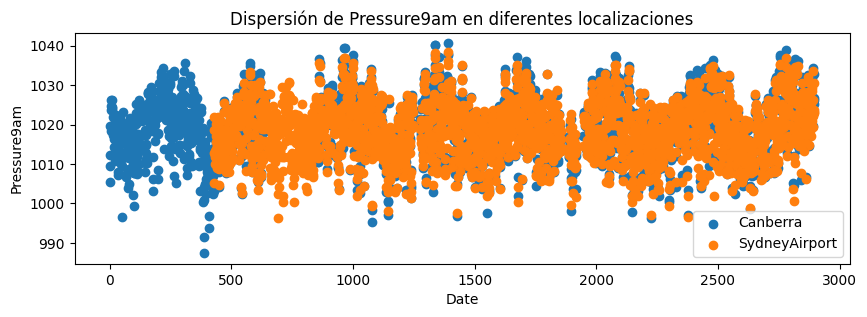

,Location,Pressure9am NaN Count,Nearest City,Distance (km)
0,Canberra,226,SydneyAirport,239.41
1,Cobar,28,Canberra,519.56
2,Adelaide,6,MountGambier,376.54
3,Sydney,1,SydneyAirport,8.49


In [88]:
variable='Pressure9am'
location='Canberra'
location_near='SydneyAirport'
graf_dispersion_comparativa(df_train_cleared, [location, location_near], 'Date',variable)
analisis_geo_nan(df_train_cleared, variable, dist_matrix, cities_coords)

In [86]:
df_train_cleared = recrear_geo_nan(df_train_cleared,'Cobar','Canberra','Sunshine')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','Melbourne','Sunshine')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Adelaide','Dartmoor','Sunshine')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','SydneyAirport','Evaporation')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Sydney','SydneyAirport','WindGustSpeed')

La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0


In [ ]:
#df_train_cleared = recrear_geo_nan(df_train_cleared,location,location_near,variable)

In [84]:
# Imprimir el resultado
print(f'Número de filas con al menos un valor NaN: {nan_rows_count}')

### Cantidad de valores faltantes.
print(df_train_cleared.isna().sum().sort_values(ascending=False))

# Contar filas que contienen al menos un valor NaN
nan_rows_count = df_train_cleared.isna().any(axis=1).sum()

Número de filas con al menos un valor NaN: 5949
Cloud3pm            3647
Cloud9am            3414
Evaporation         1055
WindDir9am           878
WindGustDir          792
WindGustSpeed        790
RainTomorrow         742
RainToday            742
WindDir3pm           272
Pressure9am          261
Pressure3pm          253
WindSpeed9am         249
WindSpeed3pm         241
RainfallTomorrow     119
Rainfall             119
Humidity9am           77
Sunshine              55
Humidity3pm           29
Temp9am               27
Temp3pm               17
MinTemp                8
MaxTemp                5
Location               0
Date                   0
dtype: int64
